# Pytorch RNN Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

It differs from the original version in that it uses an RNN rather than LSTM.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable

In [36]:
# Globals

INPUT_SIZE = 60
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

# Hyper parameters

learning_rate = 0.001
num_epochs = 50

In [37]:
# Importing the training set
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values

In [38]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [39]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(INPUT_SIZE, 1258):
    X_train.append(training_set_scaled[i-INPUT_SIZE:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [40]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [41]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [42]:
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [43]:
for epoch in range(num_epochs):
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())

    output, hidden_state = rnn(inputs, hidden_state) 

    loss = criterion(output.view(-1), labels)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                                     # update the parameters
    
    print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 0.256835460663
epoch 1, loss 0.19632768631
epoch 2, loss 0.14173270762
epoch 3, loss 0.0932204723358
epoch 4, loss 0.053042229265
epoch 5, loss 0.0255727767944
epoch 6, loss 0.0165113490075
epoch 7, loss 0.0278663244098
epoch 8, loss 0.0442202724516
epoch 9, loss 0.0481995865703
epoch 10, loss 0.0413346253335
epoch 11, loss 0.0309223849326
epoch 12, loss 0.0222198814154
epoch 13, loss 0.0173036921769
epoch 14, loss 0.0159930251539
epoch 15, loss 0.0170707385987
epoch 16, loss 0.019151084125
epoch 17, loss 0.0211174618453
epoch 18, loss 0.0222656149417
epoch 19, loss 0.0222863983363
epoch 20, loss 0.0211854036897
epoch 21, loss 0.0191942509264
epoch 22, loss 0.0166893862188
epoch 23, loss 0.0141158187762
epoch 24, loss 0.0119068892673
epoch 25, loss 0.0103955511004
epoch 26, loss 0.00972605962306
epoch 27, loss 0.00979404244572
epoch 28, loss 0.0102571332827
epoch 29, loss 0.0106476237997
epoch 30, loss 0.0105643197894
epoch 31, loss 0.00985239818692
epoch 32, loss 0.00866

In [44]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - INPUT_SIZE:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(INPUT_SIZE, 80):
    X_test.append(inputs[i-INPUT_SIZE:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [81]:
X_train_X_test = np.concatenate((X_train, X_test),axis=0)
hidden_state = None
test_inputs = Variable(torch.from_numpy(X_train_X_test).float())
predicted_stock_price, b = rnn(test_inputs, hidden_state)
predicted_stock_price = np.reshape(predicted_stock_price.detach().numpy(), (test_inputs.shape[0], 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price_all = np.concatenate((training_set[INPUT_SIZE:], real_stock_price))

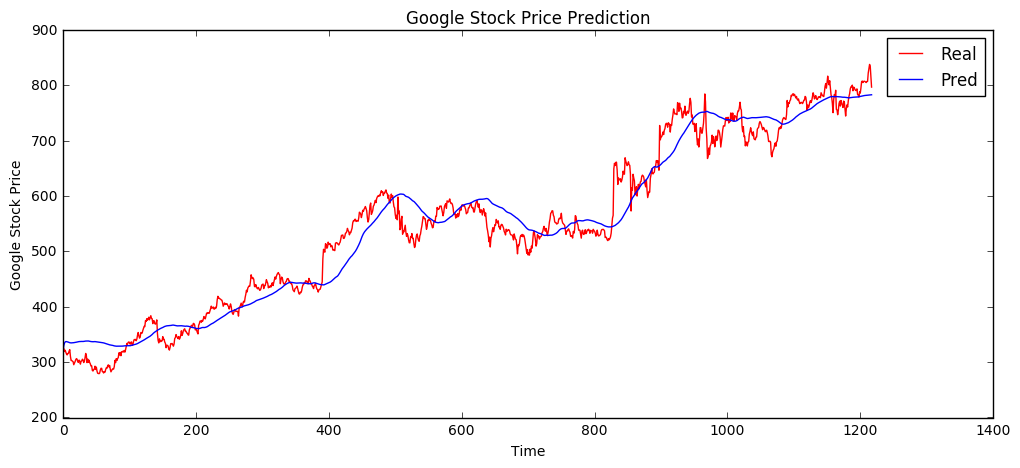

In [83]:
# Visualising the results
plt.figure(1, figsize=(12, 5))
plt.plot(real_stock_price_all, color = 'red', label = 'Real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Pred')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()